<a href="https://colab.research.google.com/github/LauJohansson/DeepLearning_NLP_Friends/blob/master/Merge_af_NLP_Friends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction**

We build a Recurrent Neural Network (RNN) using the Long Short-Term Memory (LSTM) architecture. Through tuning of hyperparameters and regularization through variational sequence length and DropConnect we achieve a perplexity value on the Penn Treebank dataset. We then utilize the found model to generate dialogue for the TV-series “Friends”. To this end, we pretrain the model on Wikipedia text and further tune the hyperparameters to fit “Friends”. Finally, we show a subset of the predicted dialogue and visualise the found semantics of “Friends” through t-SNE on the embedding weights.  




##Acknowledgements


This notebook is inspired by the following NLP Tutorial:https://github.com/graykode/nlp-tutorial
Made by Tae-Hwan Jung. 

# **Initialising Friends data**


![alt text](https://drive.google.com/uc?id=1JzPdBavHFL-8R1Tc0F6z9KlELR326MXy)


In [0]:
import collections
import pickle
import pandas as pd
import glob
import matplotlib. pyplot as plt
from collections import Counter
# Importing drive method from colab for accessing google drive
from google.colab import drive

# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/content/drive')

friends_train = open("/content/drive/My Drive/DL_project/friends_train.txt").read()
friends_valid = open("/content/drive/My Drive/DL_project/friends_valid.txt").read()
friends_test = open("/content/drive/My Drive/DL_project/friends_test.txt").read()

pretraining_train = open("/content/drive/My Drive/DL_project/wikitrainclean.txt").read()
pretraining_valid = open("/content/drive/My Drive/DL_project/wikivalidclean.txt").read()
pretraining_test = open("/content/drive/My Drive/DL_project/wikitestclean.txt").read()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# check data
print("Traindata snippet friends:    " + friends_train[:100])
print("Validdata snippet friends:    " + friends_valid[:100])
print("Testdata snippet friends:     " + friends_test[:100])
print()
print("Traindata snippet pretraining:       " + pretraining_train[:100])
print("Validdata snippet pretraining:       " + pretraining_valid[:100])
print("Testdata snippet pretraining:        " + pretraining_test[:100])

Traindata snippet friends:    [ scene: central perk , chandler , joey , phoebe , and monica are there . ] monica: there's nothing 
Validdata snippet friends:    parts that i really wanted . you always believed in me man . even , even when i didn't believe in my
Testdata snippet friends:     is at the half - opened door ] phoebe: ( in a strange heavy accent ) hello <unk> , it's time for you

Traindata snippet pretraining:       valkyria chronicles iii senj\u014d no valkyria 3 : <unk> chronicles ( japanese : \u6226\u5834\u306e\
Validdata snippet pretraining:       homarus gammarus homarus gammarus , known as the european lobster or common lobster , is a species o
Testdata snippet pretraining:        robert <unk> robert <unk> is an english film , television and theatre actor . he had a guest @ - @ s


In [0]:
# Find words that occur in friends data, but not in pretraining data
words_notinpretraining = list(set(friends_train.split()).difference(pretraining_train.split()))
words_notinpretraining[0:5]

['mah', 'curtains', 'heck', 'planetarium', 'father;']

# **Initialising Penn Tree Bank data**
![alt text](https://drive.google.com/uc?id=1A8SY9dmsLx2hoanWWWhT_IJnJcJOmluR)


The following site is used as inspiration to get PTB data: https://corochann.com/penn-tree-bank-ptb-dataset-introduction-1456.html




In [0]:
'''
#Get PTB data
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
 
 
import numpy as np
 
import chainer
train, val, test = chainer.datasets.get_ptb_words()

ptb_dict = chainer.datasets.get_ptb_words_vocabulary()
print('Number of vocabulary', len(ptb_dict))
print('ptb_dict', ptb_dict)

ptb_word_id_dict = ptb_dict
ptb_id_word_dict = dict((v,k) for k,v in ptb_word_id_dict.items())


#Create data as str
dataPTB=' '.join([ptb_id_word_dict[i] for i in train[:]])
dataPTBtest=' '.join([ptb_id_word_dict[i] for i in test[:]])
dataPTBvalid=' '.join([ptb_id_word_dict[i] for i in val[:]])
'''

"\n#Get PTB data\nfrom __future__ import print_function\nimport os\nimport matplotlib.pyplot as plt\n%matplotlib inline\n \n \nimport numpy as np\n \nimport chainer\ntrain, val, test = chainer.datasets.get_ptb_words()\n\nptb_dict = chainer.datasets.get_ptb_words_vocabulary()\nprint('Number of vocabulary', len(ptb_dict))\nprint('ptb_dict', ptb_dict)\n\nptb_word_id_dict = ptb_dict\nptb_id_word_dict = dict((v,k) for k,v in ptb_word_id_dict.items())\n\n\n#Create data as str\ndataPTB=' '.join([ptb_id_word_dict[i] for i in train[:]])\ndataPTBtest=' '.join([ptb_id_word_dict[i] for i in test[:]])\ndataPTBvalid=' '.join([ptb_id_word_dict[i] for i in val[:]])\n"

#***Import and initializing hyperparameters***


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from collections import Counter
import os
from argparse import Namespace

flags = Namespace(
    mode = 'pretraining', #'pretraining' is pretraining and 'friends' is fine-tuning.
    name='Friends',
    train_file_pretraining = pretraining_train,                    #shift between data (data or dataPTB)
    valid_file_pretraining = pretraining_valid, 
    test_file_pretraining = pretraining_test,   
    train_file_friends= friends_train,                    #shift between data (data or dataPTB)
    valid_file_friends= friends_valid, 
    test_file_friends = friends_test,
    seq_size= 32, #16,
    batch_size=40, #16,
    embedding_size=256, #300,
    lstm_size=512, #,300,                      #Hidden size
    gradients_norm=0.5,
    #initial_words=['banknote', 'berlitz'],
    initial_words_train = [],
    initial_words_valid= [],
    predict_top_k=5,                    #Choose the k best next_word_prediction, and a random is chosing.
    checkpoint_path='checkpoint',
    total_epochs=100,   #30                  #Change number of epochs in training
    learning_rate=0.001,
    predict_every=1000,
    #validation_corpus_size=len(valid_file.split()),
    dropconnect_rate=0.4,
    n_lay=2,

    #Set variational sequence length on/off
    var_seq='Y',                            #Choose if variational sequence length is on/off
    var_seq_std=2,                          #Choose std. dev. for norm distribution for var. seq. length ( in moment 1/2 of seq length)


    #scheduler parameters
    schedule_on='N',                        #Choose if LR-scheduler is on/off
    triangular='N',                         #Choose 'Y' to turn on the slanted triangular LR. 
    cut_fracI=0.2,                          #Choose the fraction of iterations we increase the LR in STL
    ratioI=32,                              #Choose how much smaller the lowest LR is from the maximum LR ηmax
    nmaxI=0.0,                              #this will be set = learning_rate 

    #Use same drop-mask for drop-connect
    same_drop_lstm='N',                     #Choose 'Y' if drop-connect all should use same mask
    
    #Dropout on embedding layer
    drop_embed=0.5,                         #Choose dropoutrate for embedding dropout        

    #Optimizer selection
    optim_select='AdamW'                      #Choose between "AdamW, SGD, ASGD"






)


#initialising two random words, the train and test data should use
if flags.mode == 'friends':
  for i in range(0,1):
    flags.initial_words_train.append(np.random.choice(flags.train_file_friends.split()))
    flags.initial_words_valid.append(np.random.choice(flags.valid_file_friends.split()))
    flags.validation_corpus_size = len(flags.valid_file_friends.split())
    
if flags.mode == 'pretraining':
  for i in range(0,1):
    flags.initial_words_train.append(np.random.choice(flags.train_file_pretraining.split()))
    flags.initial_words_valid.append(np.random.choice(flags.valid_file_pretraining.split()))
    flags.validation_corpus_size = len(flags.valid_file_pretraining.split())

flags.nmaxI=flags.learning_rate

#**Define functions and set up model**

##Function to get data for main and batch-function

In [0]:
def get_data_from_file(train_file, batch_size, seq_size):
  
    text=train_file.split()
    # Extend words_notinpretraining to text to get them as a part of the mapping dictionary
    text.extend(words_notinpretraining)
    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)

    text=train_file.split()

    print('Vocabulary size', n_vocab)

    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:]
    out_text[-1] = in_text[0]
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text

In [0]:
def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

##Setting up the model

In [0]:
class RNNModule(nn.Module):
    def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
        super(RNNModule, self).__init__()
        self.seq_size = seq_size
        self.lstm_size = lstm_size
        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm=nn.LSTM(embedding_size,
                            lstm_size,
                            batch_first=True,num_layers=flags.n_lay)
        
        self.dense = nn.Linear(lstm_size, n_vocab)
        self.drop_out=nn.Dropout(flags.drop_embed)
        self.OneMaskOnly=torch.autograd.Variable(torch.Tensor(getattr(self.lstm,self.lstm._all_weights[0][0]).shape[0],
                                                        getattr(self.lstm,self.lstm._all_weights[0][0]).shape[1]).uniform_().to("cuda") > flags.dropconnect_rate)


    def forward(self, x, prev_state):
        embed = self.embedding(x)
        embed=self.drop_out(embed)
        orig=[]

        #Make dropconnect
        if self.training:
          for i in range( len(self.lstm._all_weights[0])):
            name = self.lstm._all_weights[0][i]
            if name.find('LSTM.weight_hh_l')!=-1:      
              orig.append(getattr(self.lstm,name))
            
              if flags.same_drop_lstm=='Y':
                mask=self.OneMaskOnly
              else:
                mask=torch.autograd.Variable(torch.Tensor(getattr(self.lstm,name).shape[0],
                                                        getattr(self.lstm,name).shape[1]).uniform_().to("cuda") > flags.flags.dropconnect_rate)
              setattr(self.lstm,name,torch.nn.Parameter(torch.mul(getattr(self.lstm,name),mask)))
              
              self.lstm.flatten_parameters()
             

        #LSTM forward
        output, state = self.lstm(embed, prev_state)

        #Set hh-weight back to original
        if self.training:
          a=0
          for i in range( len(self.lstm._all_weights[0])):
            name = self.lstm._all_weights[0][i]
            if name.find('LSTM.weight_hh_l')!=-1:
              print(orig)
              setattr(self.lstm,name,orig[a])
              #self.lstm.weight_hh_l0=orig
              self.lstm.flatten_parameters()
              a=+1

        logits = self.dense(output)

        return logits, state
       
    def zero_state(self, batch_size):
        return (torch.zeros(flags.n_lay, batch_size, self.lstm_size),
                torch.zeros(flags.n_lay, batch_size, self.lstm_size))

##Defining ASGD
from: https://pytorch.org/docs/stable/_modules/torch/optim/asgd.html


In [0]:
#import torch
#from .optimizer import Optimizer


class ASGD(torch.optim.Optimizer):
    """Implements Averaged Stochastic Gradient Descent.

    It has been proposed in `Acceleration of stochastic approximation by
    averaging`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-2)
        lambd (float, optional): decay term (default: 1e-4)
        alpha (float, optional): power for eta update (default: 0.75)
        t0 (float, optional): point at which to start averaging (default: 1e6)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)

    .. _Acceleration of stochastic approximation by averaging:
        http://dl.acm.org/citation.cfm?id=131098
    """

    def __init__(self, params, lr=1e-2, lambd=1e-4, alpha=0.75, t0=1e6, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, lambd=lambd, alpha=alpha, t0=t0,
                        weight_decay=weight_decay)
        super(ASGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('ASGD does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['eta'] = group['lr']
                    state['mu'] = 1
                    state['ax'] = torch.zeros_like(p.data)

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # decay term
                p.data.mul_(1 - group['lambd'] * state['eta'])

                # update parameter
                p.data.add_(-state['eta'], grad)

                # averaging
                if state['mu'] != 1:
                    state['ax'].add_(p.data.sub(state['ax']).mul(state['mu']))
                else:
                    state['ax'].copy_(p.data)

                # update eta and mu
                state['eta'] = (group['lr'] /
                                math.pow((1 + group['lambd'] * group['lr'] * state['step']), group['alpha']))
                state['mu'] = 1 / max(1, state['step'] - group['t0'])

        return loss

##Define function to call optimizer

In [0]:
def get_loss_and_train_op(net, lrI):
    criterion = nn.CrossEntropyLoss()
    if (flags.optim_select=='ASGD'):
      optimizer = torch.optim.ASGD(net.parameters(), lr=lrI,weight_decay=0,t0=0,lambd=0) #decay, t0 and lambd taken from article
    elif (flags.optim_select=='SGD'):
      optimizer = torch.optim.SGD(net.parameters(), lr=lrI) #decay, t0 and lambd taken from article
    else:  
      optimizer = torch.optim.AdamW(net.parameters(), lr=lrI,weight_decay=0.3)
  
    return criterion, optimizer

##Define function to schedule optimizer for ASGD


Article used: [Universal Language Model Fine-tuning for Text Classification](https://www.aclweb.org/anthology/P18-1031.pdf?fbclid=IwAR0-TADs3LWh74b4xbA2QW5OYM5-_5iFu2EBjd_0-KVWOUytnBV5TeS9KGo)

In [0]:
#T=number of epochs * number of updates per epoch
#"cut_frac" is the fraction of iterations we increase the LR
# "cut" is the iteration when we switch from increasing to decreasing the LR
# "p" is the fraction of the number of iterations we have increased or will decrease the LR respectively
# "ratio" specifies how much smaller the lowest LR is from the maximum LR nmax
#"nt"/return value is the learning rate at iteration t.

#The paper generally use cut_frac = 0.1, ratio = 32 and ηmax = 0.01


def triangular_lr_func(t,T,cut_frac=flags.cut_fracI, ratio=flags.ratioI, nmax=flags.nmaxI ):
    cut=np.floor(T*cut_frac)

    if (t<cut): p=t/cut
    else: p=1-((t-cut)/(cut*(ratio-1)))


    return nmax * (1+p*(ratio-1))/ratio

##Custommade scheduler
This scheduler is an example on how ASGD LR can be decreased for each iteration. 

In [0]:
def easy_schedule(t,nmax=flags.nmaxI):
  result = nmax-(t*0.0001)

  if(result<0.1): result=0.1

  return result


#**Define main**

In [0]:
def main():
    torch.manual_seed(11)
    print('------------------------------------------------------------------------  ')
    print('----------------------Go into training mode--------------------------------  ')
    print("----------------------using %s data------------------------" % flags.mode)
    print('------------------------------------------------------------------------  ')
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Pre-training mode on pretrainingtext
    # Start network from scratch
    if flags.mode == 'pretraining': 
      int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(
          flags.train_file_pretraining, flags.batch_size, flags.seq_size)
           
    # Fine-tuning mode on friends
    if flags.mode == 'friends': 

      # Get int_to_vocab, vocab_to_int, n_vocab from pretraining text pre-training
      int_to_vocab, vocab_to_int, n_vocab, _, _ = get_data_from_file( 
          flags.train_file_pretraining, flags.batch_size, flags.seq_size)
      
      # Load and store data for friends-training
      text = flags.train_file_friends.split()
      int_text = [vocab_to_int[v] for v in text]
      var1 = len(int_text) % flags.batch_size 
      in_text =   int_text[:] if var1==0 else  int_text[:-var1]              ## Added -19 to make divisble with 20 batch size
      out_text = np.zeros_like(in_text)
      out_text[:-1] = in_text[1:]
      out_text[-1] = in_text[0]
      in_text = np.reshape(in_text, (flags.batch_size, -1))
      out_text = np.reshape(out_text, (flags.batch_size, -1))


    if flags.mode == 'pretraining': 
      # Load and store data for validation
      valid_text = flags.valid_file_pretraining.split()
      valid_int_text = [vocab_to_int[v] for v in valid_text]
      var2 = len(valid_int_text) % flags.batch_size
      valid_in_text =  valid_int_text[:] if var2==0 else valid_int_text[:-var2] ## Added -19 to make divisble with 20 batch size
      valid_out_text = np.zeros_like(valid_in_text)
      valid_out_text[:-1] = valid_in_text[1:]
      valid_out_text[-1] = valid_in_text[0]
      valid_in_text = np.reshape(valid_in_text, (flags.batch_size, -1))
      valid_out_text = np.reshape(valid_out_text, (flags.batch_size, -1))

      test_text = flags.test_file_pretraining.split()
      test_int_text = [vocab_to_int[v] for v in test_text]
      var3 = len(test_int_text) % flags.batch_size
      test_in_text =  test_int_text[:] if var3==0 else test_int_text[:-var3]
      test_out_text = np.zeros_like(test_in_text)
      test_out_text[:-1] = test_in_text[1:]
      test_out_text[-1] = test_in_text[0]
      test_in_text = np.reshape(test_in_text, (flags.batch_size, -1))
      test_out_text = np.reshape(test_out_text, (flags.batch_size, -1))

    
    if flags.mode == 'friends': 
      # Load and store data for validation
      valid_text = flags.valid_file_friends.split()
      valid_int_text = [vocab_to_int[v] for v in valid_text]
      var4 = len(valid_int_text) % flags.batch_size
      valid_in_text = valid_int_text[:] if  var4==0 else  valid_int_text[:-var4]
      valid_out_text = np.zeros_like(valid_in_text)
      valid_out_text[:-1] = valid_in_text[1:]
      valid_out_text[-1] = valid_in_text[0]
      valid_in_text = np.reshape(valid_in_text, (flags.batch_size, -1))
      valid_out_text = np.reshape(valid_out_text, (flags.batch_size, -1))

      test_text = flags.test_file_friends.split()
      test_int_text = [vocab_to_int[v] for v in test_text]
      var5 = len(test_int_text) % flags.batch_size
      test_in_text = test_int_text[:] if  var5==0 else  test_int_text[:-var5]
      test_out_text = np.zeros_like(test_in_text)
      test_out_text[:-1] = test_in_text[1:]
      test_out_text[-1] = test_in_text[0]
      test_in_text = np.reshape(test_in_text, (flags.batch_size, -1))
      test_out_text = np.reshape(test_out_text, (flags.batch_size, -1))


    if flags.mode == 'pretraining': 
      net = RNNModule(n_vocab, flags.seq_size,
                      flags.embedding_size, flags.lstm_size)
      net = net.to(device)

    if flags.mode == 'friends':  
      net = RNNModule(n_vocab, flags.seq_size,
                      flags.embedding_size, flags.lstm_size)
      net.load_state_dict(torch.load('/content/drive/My Drive/DL_project/net.pth'))
      net = net.to(device)
      net.eval()

    criterion, optimizer = get_loss_and_train_op(net, flags.learning_rate)


    

    #Documentation from: https://pytorch.org/docs/master/optim.html

    if (flags.schedule_on=='Y'):
      expected_number_of_epochs= (np.prod(in_text.shape) // (flags.seq_size * flags.batch_size))*flags.total_epochs
      
    if (flags.triangular=='Y'):
        lambda1= lambda iteration_schedule: triangular_lr_func(iteration_schedule,expected_number_of_epochs)
    else:
        lambda1= lambda iteration_schedule: easy_schedule(iteration_schedule)


    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

    iteration = 0

    if (flags.schedule_on=='Y'):
      iteration_schedule=0

    epochnumber = []
    all_train_losses = []
    all_valid_losses = []
    all_test_losses = []
    for e in range(flags.total_epochs): #Implemented flags.total_epochs to change parameter
        epochnumber.extend([e+1])

        ######################## TRAINING EPOCH ###########################


        ###Variational sequence length###

        if (flags.var_seq=='Y'):
          base_length=np.round(np.random.normal(flags.seq_size, flags.seq_size/flags.var_seq_std)).astype(int)
          if (base_length<2):
            base_length=2
        else:
          base_length=flags.seq_size

        #########################



        batches = get_batches(in_text, out_text, flags.batch_size, base_length)
        valid_batches = get_batches(valid_in_text, valid_out_text, flags.batch_size, base_length)
        test_batches = get_batches(test_in_text, test_out_text, flags.batch_size, base_length)

        state_h, state_c = net.zero_state(flags.batch_size)
        
        # Transfer data to GPU
        state_h = state_h.to(device)
        state_c = state_c.to(device)

        for x, y in batches:
            iteration += 1


            if (flags.schedule_on=='Y'):
              iteration_schedule+=1
            
            # Tell it we are in training mode
            net.train()

            # Reset all gradients
            optimizer.zero_grad()

            # Transfer data to GPU
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss_value = loss.item()        

            # Perform back-propagation
            loss.backward()

            _ = torch.nn.utils.clip_grad_norm_(
                net.parameters(), flags.gradients_norm)
            
            # Update the network's parameters
            optimizer.step()

            #Scheduler step
            if (flags.schedule_on=='Y'):
              scheduler.step()


            if iteration % 100 == 0:
                print('Epoch: {}/{}'.format(e, flags.total_epochs), 
                      'Iteration: {}'.format(iteration),
                      '\t Loss: {}'.format(loss_value))
                      #'\t Perplexity: {}'.format(2**loss_value))
        

        logits, (state_h, state_c) = net(x, (state_h, state_c))
        loss = criterion(logits.transpose(1, 2), y)
        loss_value_final = loss.item()    
        all_train_losses.append(loss_value_final) 
        print('Final training loss {}'.format(loss_value_final)) 
        

        ##################### VALIDATION EPOCH ########################
        iteration = 0

        state_h, state_c = net.zero_state(flags.batch_size)
        # Transfer data to GPU

        state_h = state_h.to(device)
        state_c = state_c.to(device)

        for x, y in valid_batches:

            iteration += 1

            # Tell it we are in evaluation mode
            net.eval()

            # Transfer data to GPU
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            valid_loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            valid_loss_value = valid_loss.item()

        all_valid_losses.append(valid_loss_value)


        ##################### TEST EPOCH ########################
        iteration = 0

        state_h, state_c = net.zero_state(flags.batch_size)
        # Transfer data to GPU

        state_h = state_h.to(device)
        state_c = state_c.to(device)

        for x, y in test_batches:

            iteration += 1

            # Tell it we are in evaluation mode
            net.eval()

            # Transfer data to GPU
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            test_loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            test_loss_value = test_loss.item()

        all_test_losses.append(test_loss_value)


        print('')
       # print('Current mean of validation loss over batches: {}'.format(mean_all_valid_losses))
        print('Current validation loss: {}'.format(valid_loss_value))
        print('Validation perplexity: {}'.format(np.exp((valid_loss_value))))
        print(' ')
        print('Current test loss: {}'.format(test_loss_value))
        print('Test perplexity: {}'.format(np.exp((test_loss_value))))

        print('')
            
        plt.figure()                             
        plt.xlabel('Epochs'), plt.ylabel('Loss')   
        plt.plot(epochnumber, all_train_losses, 'r', epochnumber, all_valid_losses, 'b', epochnumber, all_test_losses, 'g')
        plt.legend(['Train Loss','Validation Loss', 'Test Loss'])    
   
        last= predict(device, net, flags.initial_words_train, n_vocab,
                            vocab_to_int, int_to_vocab, flags.predict_top_k)
        print('\nThe last predicted 200 characters are:\n')
        print(last[-200:])

    #path = "/content/drive/My Drive/DL_project/"
    # save the pretrained model if the validation loss is less than minimum validation loss.
        if flags.mode == 'pretraining' and e > 0 and valid_loss_value <= min(all_valid_losses):
          torch.save(net.state_dict(), '/content/drive/My Drive/DL_project/net.pth')
          print('Saved model')

##Define a prediction function

In [0]:
def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k):
    net.eval()

    state_h, state_c = net.zero_state(1)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for w in words:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))
    

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0]) #Looks like a way to avoid always choose like "and" "then"..... 

    words.append(int_to_vocab[choice])

    for _ in range(100):
        ix = torch.tensor([[choice]]).to(device)
        output, (state_h, state_c) = net(ix, (state_h, state_c))

        _, top_ix = torch.topk(output[0], k=top_k)
        choices = top_ix.tolist()
        choice = np.random.choice(choices[0])
        words.append(int_to_vocab[choice])

    print(' '.join(words))
    return ' '.join(words)

#***Run model***

------------------------------------------------------------------------  
----------------------Go into training mode--------------------------------  
----------------------using pretraining data------------------------
------------------------------------------------------------------------  
Vocabulary size 33347
Epoch: 0/100 Iteration: 100 	 Loss: 6.88864278793335
Epoch: 0/100 Iteration: 200 	 Loss: 7.000919342041016
Epoch: 0/100 Iteration: 300 	 Loss: 6.9633307456970215
Epoch: 0/100 Iteration: 400 	 Loss: 6.703431129455566
Epoch: 0/100 Iteration: 500 	 Loss: 6.856640815734863
Epoch: 0/100 Iteration: 600 	 Loss: 6.751343727111816
Epoch: 0/100 Iteration: 700 	 Loss: 6.644401550292969
Epoch: 0/100 Iteration: 800 	 Loss: 6.678958892822266
Epoch: 0/100 Iteration: 900 	 Loss: 6.440627098083496
Epoch: 0/100 Iteration: 1000 	 Loss: 6.517574310302734
Epoch: 0/100 Iteration: 1100 	 Loss: 6.427817344665527
Epoch: 0/100 Iteration: 1200 	 Loss: 6.7350616455078125
Epoch: 0/100 Iteration: 1300 

KeyboardInterrupt: ignored

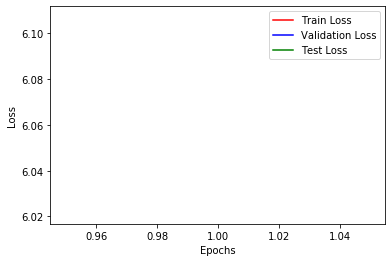

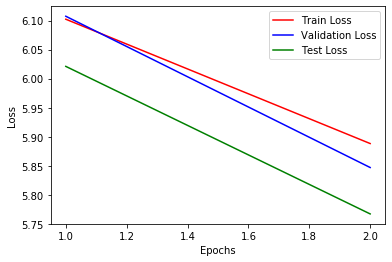

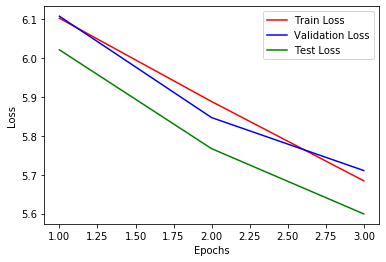

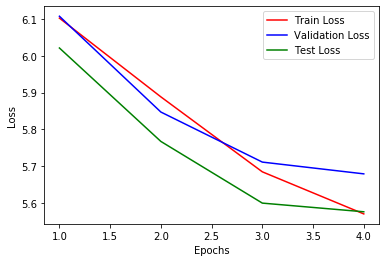

In [0]:
if __name__ == '__main__':
    main()